In [2]:
import matplotlib.pyplot as plt
import torch
from loader import *
from models.fast import FAST
from models.loss.balanced_bce_loss import BalancedBCELoss
from models.loss.dice_loss import DiceLoss
from models.loss.ohem import get_ohem_masks
from train import calculate_total_loss
from models.utils import evaluate_micro

%load_ext autoreload
%autoreload 2

/home/zachhendon/miniconda3/envs/text-detection/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [3]:
model = FAST().cuda()
# checkpoint = torch.load("checkpoints/fast_icdar2015_finetune_015/recent.pth", weights_only=True)
checkpoint = torch.load("checkpoints/fast_synthtext_028/recent.pth", weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
print(f"Iteration: {checkpoint["iteration"]}")

# train_loader, val_loader = get_icdar2015_loaders(batch_size=1)
train_loader, val_loader = get_synthtext_loaders(batch_size=1)

Iteration: 52500


Kernel Loss: 0.11003726720809937
Text Loss: 0.12297940254211426
Total Loss: 0.1715269684791565


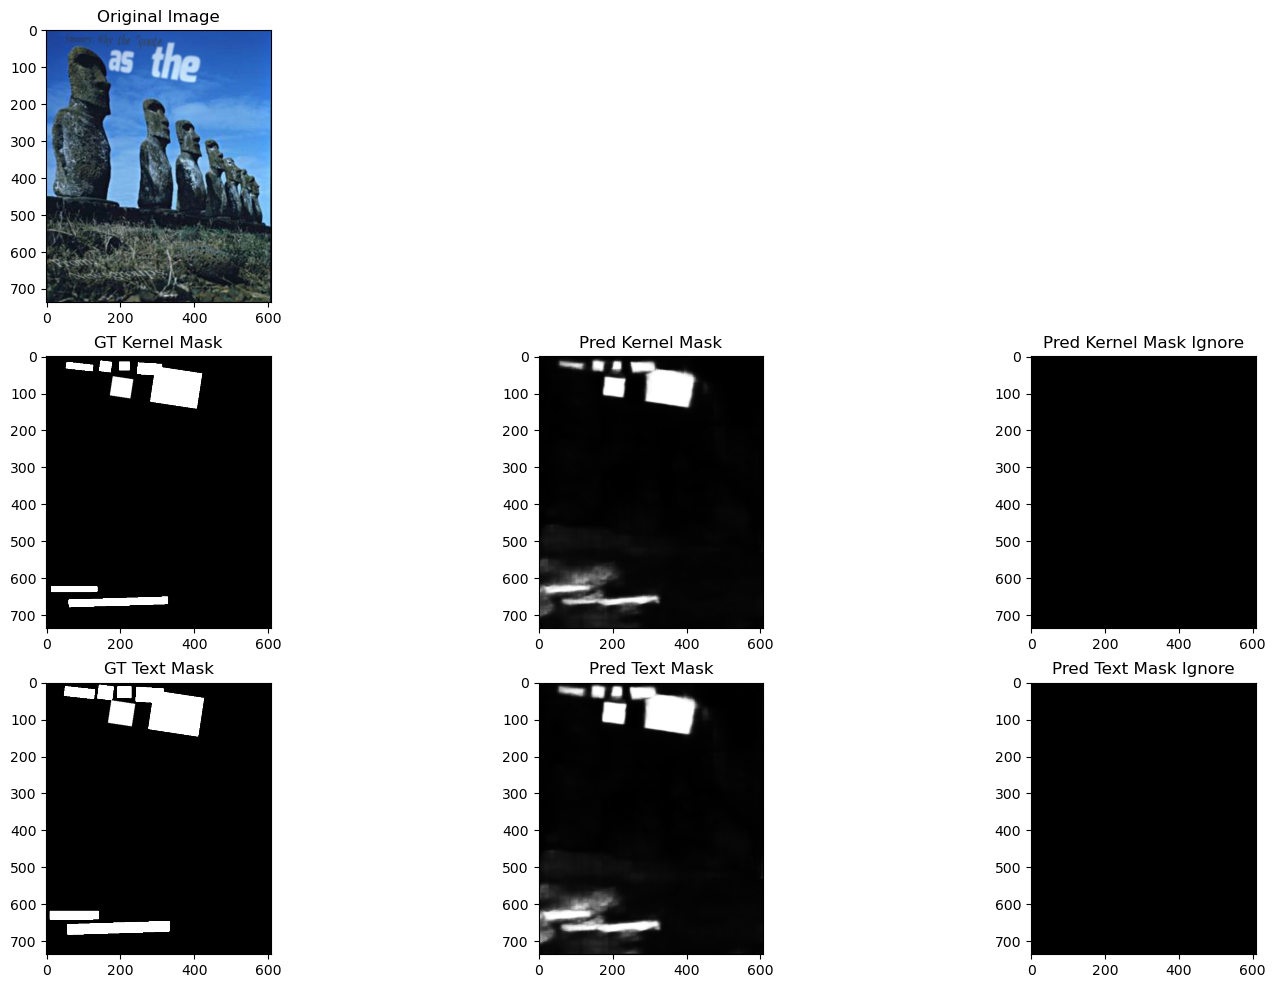

In [4]:
data = next(val_loader)
i = 0
images = data[0]
kernel_masks = data[1]
ignore_kernel_masks = data[2]
text_masks = data[3]
ignore_text_masks = data[4]

preds = model(images)
# preds = preds * (1 - torch.clamp(ignore_text_masks, 0, 1))
dilated_preds = torch.nn.functional.max_pool2d(
    preds, kernel_size=5, stride=1, padding=2
)
# dilated_preds = dilated_preds * (1 - torch.clamp(ignore_text_masks, 0, 1))

fig, axs = plt.subplots(3, 3, figsize=(18, 12))
fig.delaxes(axs[0][1])
fig.delaxes(axs[0][2])

# original image
image = (images[i] - images[i].min()) / (images[i].max() - images[i].min())
axs[0][0].imshow(image.permute(1, 2, 0).cpu().numpy())
axs[0][0].set_title("Original Image")

# gt kernel mask
axs[1][0].imshow(kernel_masks.cpu().numpy()[i],vmin=0, vmax=1, cmap='gray')
axs[1][0].set_title("GT Kernel Mask")
# pred kernel mask
axs[1][1].imshow(preds.cpu().detach().numpy()[i],vmin=0, vmax=1, cmap='gray')
axs[1][1].set_title("Pred Kernel Mask")
# pred kernel mask ignore
axs[1][2].imshow((ignore_kernel_masks).cpu().detach().numpy()[i],vmin=0, vmax=1, cmap='gray')
axs[1][2].set_title("Pred Kernel Mask Ignore")

# gt text mask
axs[2][0].imshow(text_masks.cpu().numpy()[i],vmin=0, vmax=1, cmap='gray')
axs[2][0].set_title("GT Text Mask")
# pred text mask
axs[2][1].imshow(dilated_preds.cpu().detach().numpy()[i],vmin=0, vmax=1, cmap='gray')
axs[2][1].set_title("Pred Text Mask")
# pred text mask ignore
axs[2][2].imshow((ignore_text_masks).cpu().detach().numpy()[i],vmin=0, vmax=1, cmap='gray')
axs[2][2].set_title("Pred Text Mask Ignore")


selected_masks = get_ohem_masks(dilated_preds, text_masks, ignore_text_masks)
loss_text = DiceLoss()(dilated_preds, text_masks, selected_masks)
# selected_masks = 1 - torch.clamp(ignore_text_masks, 0, 1)
loss_kernel = DiceLoss()(preds, kernel_masks, selected_masks)
total_loss = calculate_total_loss(loss_kernel, loss_text)
# kernel_loss = BalancedBCELoss()(preds, kernel_masks, ignore_text_masks)
# text_loss = DiceLoss()(dilated_preds, text_masks, ignore_text_masks)
# total_loss = calculate_total_loss(kernel_loss, text_loss)
print(f"Kernel Loss: {loss_kernel.item()}")
print(f"Text Loss: {loss_text.item()}")
print(f"Total Loss: {total_loss.item()}")

plt.show()

In [421]:
dset = FastDataset("data/processed/icdar2015/train", train=True, ignore=True, batch=False)

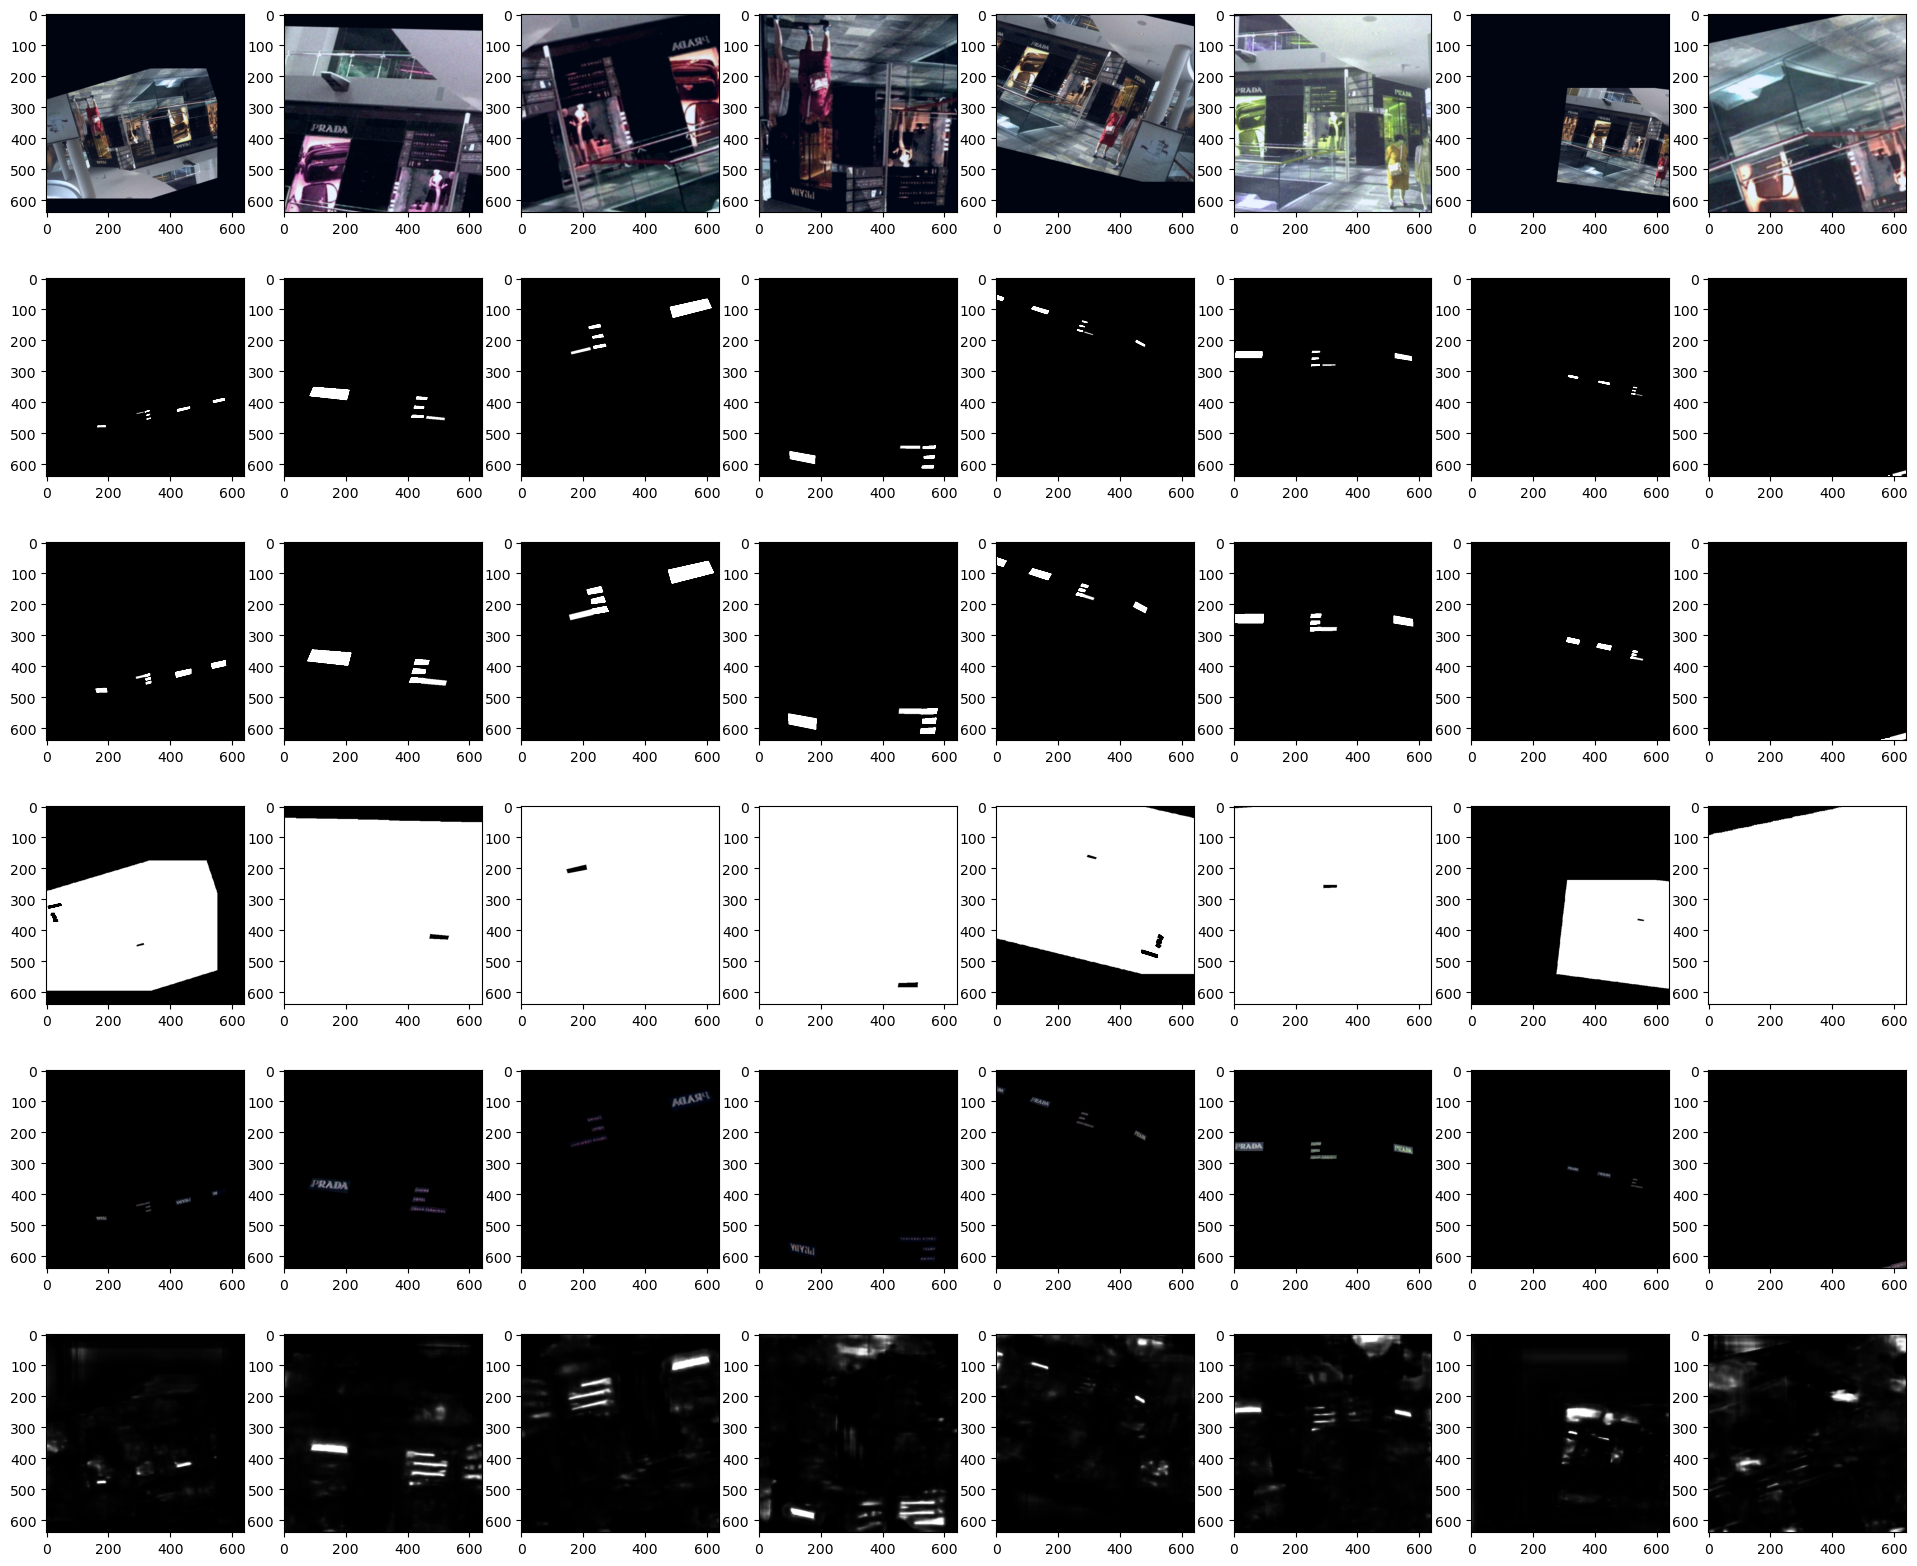

In [428]:
N = 8

fig, axs = plt.subplots(6, N, figsize=(N * 3, 20))
for i in range(N):
    img, kernel_masks, ignore_kernel_masks, text_masks, ignore_text_masks = dset[781]
    preds = model(img.unsqueeze(0).cuda())
    img = (img - img.min()) / (img.max() - img.min())
    axs[0][i].imshow(img.permute(1, 2, 0).cpu().detach())
    axs[1][i].imshow(kernel_masks.cpu().detach(), cmap='gray', vmin=0, vmax=1)
    axs[2][i].imshow(text_masks.cpu().detach(), cmap='gray', vmin=0, vmax=1)
    axs[3][i].imshow((1 - ignore_text_masks).cpu().detach(), cmap='gray', vmin=0, vmax=1)
    axs[4][i].imshow((img * torch.clip(text_masks, 0, 1)).permute(1, 2, 0).cpu().detach())
    axs[5][i].imshow(preds.cpu().detach().numpy()[0], cmap='gray', vmin=0, vmax=1)

In [153]:
img.shape

torch.Size([3, 640, 640])

In [155]:
img.sum(axis=0).shape

torch.Size([640, 640])

In [330]:
train_loader, val_loader = get_icdar2015_loaders(batch_size=1)

In [466]:
images, kernel_masks, ignore_kernel_masks, text_masks, ignore_text_masks = (
    next(train_loader)
)
ignore_text_masks.sum()

/home/zachhendon/miniconda3/envs/text-detection/lib/python3.12/site-packages/torch/nn/functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/zachhendon/miniconda3/envs/text-detection/lib/python3.12/site-packages/torch/nn/functional.py:4969: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor(11682., device='cuda:0')

In [467]:
preds = model(images)
dilated_preds = torch.nn.functional.max_pool2d(
    preds * (1 - torch.clamp(ignore_text_masks, 0, 1)),
    # preds,
    kernel_size=9,
    stride=1,
    padding=4,
)

In [468]:
img = (images[0] - images[0].min()) / (images[0].max() - images[0].min())

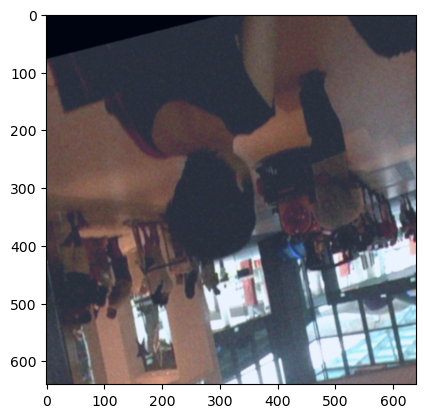

In [469]:
plt.imshow(img.permute(1, 2, 0).cpu().detach())

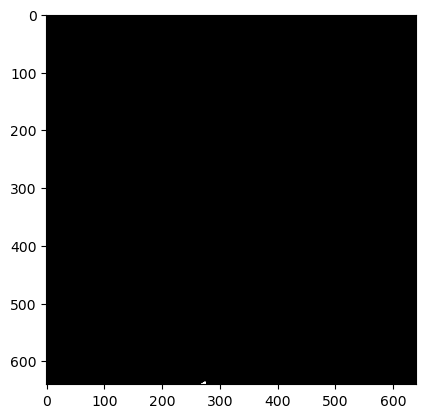

In [470]:
plt.imshow(kernel_masks.cpu().detach()[0], cmap="gray", vmin=0, vmax=1)

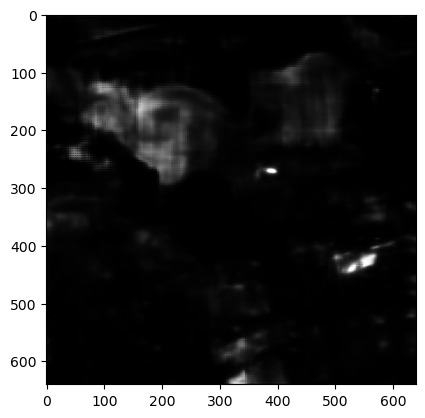

In [471]:
plt.imshow(preds[0].cpu().detach(), cmap="gray")

In [472]:
a = 1 - torch.clamp(ignore_kernel_masks, 0, 1)
b = get_ohem_masks(preds, kernel_masks, ignore_kernel_masks)
c = get_ohem_masks(preds, kernel_masks, torch.zeros_like(ignore_kernel_masks))

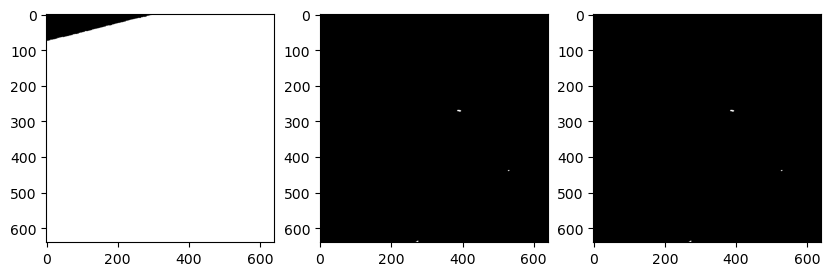

In [473]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))
axs[0].imshow(a[0].cpu().detach(), cmap='gray', vmin=0, vmax=1)
axs[1].imshow(b[0].cpu().detach(), cmap='gray', vmin=0, vmax=1)
axs[2].imshow(c[0].cpu().detach(), cmap='gray', vmin=0, vmax=1)

In [459]:
DiceLoss()(preds, kernel_masks, a)

tensor(0.8856, device='cuda:0', grad_fn=<MeanBackward0>)

In [460]:
DiceLoss()(preds, kernel_masks, b)

tensor(0.7520, device='cuda:0', grad_fn=<MeanBackward0>)

In [464]:
DiceLoss()(preds, kernel_masks, c)

tensor(0.7520, device='cuda:0', grad_fn=<MeanBackward0>)

In [462]:
BalancedBCELoss()(preds, kernel_masks, a)

tensor(0.1962, device='cuda:0', grad_fn=<DivBackward0>)

In [463]:
BalancedBCELoss()(preds, kernel_masks, b)

tensor(8.4801, device='cuda:0', grad_fn=<DivBackward0>)

In [465]:
BalancedBCELoss()(preds, kernel_masks, c)

tensor(8.4801, device='cuda:0', grad_fn=<DivBackward0>)

## Evaluate

In [3]:
# 08
train_loader, val_loader = get_icdar2015_loaders(batch_size=16)
evaluate_micro(model, val_loader, iter_limit=25)

(0.48818255908720454, 0.3201496525921967, 0.3867010974822466)

In [4]:
# 08
train_loader, val_loader = get_synthtext_loaders(batch_size=16)
evaluate_micro(model, val_loader, iter_limit=25)

(0.9405940594059405, 0.7883817427385892, 0.8577878103837472)

In [7]:
# 11
train_loader, val_loader = get_icdar2015_loaders(batch_size=16)
evaluate_micro(model, val_loader, iter_limit=25)

(0.2976190476190476, 0.09353287012292892, 0.1423342822285482)

In [8]:
# 11
train_loader, val_loader = get_synthtext_loaders(batch_size=16)
evaluate_micro(model, val_loader, iter_limit=25)

(0.6578947368421053, 0.5186721991701245, 0.5800464037122971)

In [10]:
# 18
train_loader, val_loader = get_icdar2015_loaders(batch_size=16)
evaluate_micro(model, train_loader, iter_limit=25)

(0.2846715328467153, 0.03500897666068223, 0.06235011990407673)

In [11]:
# 18
train_loader, val_loader = get_synthtext_loaders(batch_size=16)
evaluate_micro(model, train_loader, iter_limit=25)

(0.5238095238095238, 0.14329135909683022, 0.22502557108762358)

In [9]:
# 19
train_loader, val_loader = get_icdar2015_loaders(batch_size=16)
evaluate_micro(model, train_loader, iter_limit=25)

(0.2864583333333333, 0.05344995140913508, 0.0900900900900901)

In [8]:
# 19
train_loader, val_loader = get_synthtext_loaders(batch_size=16)
evaluate_micro(model, train_loader, iter_limit=25)

(0.49700598802395207, 0.19896124650419497, 0.28416547788873037)

In [9]:
# 28 - 0.88
train_loader, val_loader = get_synthtext_loaders(batch_size=16)
evaluate_micro(model, train_loader, iter_limit=100)

(0.8158882715122391, 0.5815671162491972, 0.6790825573401663)

In [10]:
# 28 0.7
train_loader, val_loader = get_synthtext_loaders(batch_size=16)
evaluate_micro(model, train_loader, iter_limit=100)

/home/zachhendon/miniconda3/envs/text-detection/lib/python3.12/site-packages/torch/nn/functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/zachhendon/miniconda3/envs/text-detection/lib/python3.12/site-packages/torch/nn/functional.py:4969: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(0.8640234538601145, 0.6565881604073839, 0.7461570920489481)